# Tutorial for Hybrid Modeling of Entanglement Distribution Sources

In this tutorial, we will explore the complete process of modeling entanglement distribution sources using a hybrid Gaussian/non-Gaussian modeling approach. The fundamental theory for this approach can be found in (the accompanying paper that this code will be published with). To being, let's call the functions needed for modeling. ?

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from genqo import ZALM
from genqo import SPDC
from genqo import TMSV

from tqdm import tqdm
import sympy as smp
import matplotlib.pyplot as plt
import hickle as hkl

## Modeling a Two-mode squeezed vacuum state

Fundamental to all of these sources is the two-mode squeezed vacuum state. As such, we will begin by modeling a single two-mode squeezed vacuum state, and verifying the functionality of the hybrid tools for correctly modeling such a state as analytical solutions for the TMSV state are readily available. 

To begin, let's define functions for the analytical expression for the probability of a coincidence measurement, i.e. the probability that we measure a single photon in each mode simultaneously. 

In [3]:
# In the ideal case, as a function of the mean photon number
def tmsvp(n,Nstst):
    num = Nstst**n
    den = (1 + Nstst)**(n+1)
    return num/den

# In the presence of loss, as a function of the mean photon number
def tmsv_1_loss(Nstst,eta):
    lam = Nstst/(1 + Nstst)
    num  = 1 + ((1 - eta)**2)*lam
    den = (1 - ((1 - eta)**2)*lam)**3
    c = (1 - lam)*lam*(eta**2)
    return c*(num/den)

Next, let's calculate the same quantity, using the hybrid toolbox functions. First, when no loss is present.

In [4]:
Pg = np.array([])
muv = np.linspace(10**(-4),10,100)
tmsv_example = TMSV()
etest = 10**(-0/10)
tmsv_example.params["detection_efficiency"] = etest

for i in tqdm(muv):
    tmsv_example.params["mean_photon"] = i
    tmsv_example.run()
    tmsv_example.calculate_probability_success()
    Pg = np.append(Pg, np.real(smp.expand(tmsv_example.results["probability_success"])))

100%|██████████| 100/100 [00:00<00:00, 255.31it/s]


Plotting

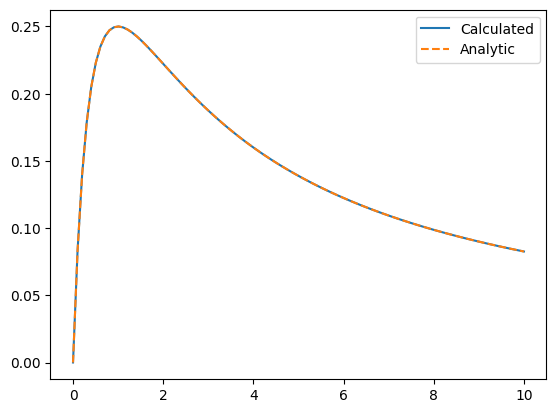

In [5]:
plt.plot(muv, Pg, label='Calculated')
plt.plot(muv, tmsv_1_loss(muv,etest), label='Analytic', linestyle='dashed')
# plt.ylim(0,1)
# plt.xscale('log')
plt.legend()

Next, introducing loss

In [6]:
from tqdm import tqdm
Pg = np.array([])
muv = np.linspace(10**(-4),10,200) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])
# muv = np.logspace(-4,1,300)
tmsv_example = TMSV()
etdb = 5
etest = 10**(-etdb/10)
tmsv_example.params["detection_efficiency"] = etest

for i in tqdm(muv):
    tmsv_example.params["mean_photon"] = i
    tmsv_example.run()
    tmsv_example.calculate_probability_success()
    Pg = np.append(Pg, tmsv_example.results["probability_success"])

100%|██████████| 200/200 [00:00<00:00, 284.68it/s]


In [7]:
tmsv_loss_vec1 = np.array([])
tmsv_loss_vec2 = np.array([])
for i in muv:
    tmsv_loss_vec1 = np.append(tmsv_loss_vec1, tmsv_1_loss(i,1))
    tmsv_loss_vec2 = np.append(tmsv_loss_vec2, tmsv_1_loss(i,etest))

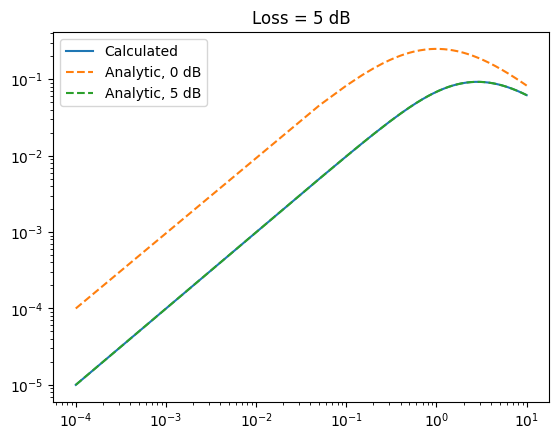

In [8]:
plt.plot(muv, Pg, label='Calculated')
plt.plot(muv, tmsv_loss_vec1, label='Analytic, 0 dB', linestyle='dashed')
plt.plot(muv, tmsv_loss_vec2, label='Analytic, 5 dB', linestyle='dashed')
# plt.ylim(0,1)
plt.yscale('log')
plt.xscale('log')
plt.title(f'Loss = {etdb} dB')
plt.legend()

We see that we reproduce the analytical results exacltly. This simple example acts as a corner case for the functionality of the hybrid modeling approach. But, it does not demonstrate any sort of advantage (something like using a sledgehammer to smash a cockroach). As we model the entanglement sources, we will see the true benefit of the hybrid modeling approach.  

## Modeling an SPDC source

With the demonstration of a TMSV state in the previous section, we are now armed with the basic capabilities for modeling an SPDC source, which is composed of two TMSV states and an idler mode swap. We will show how to calculate the photon-photon density matrix for this source, as well as the spin-spin density matrix when the source state has been loaded into Duan-Kimble style quantum memories.

### Calculating the photon-photon density matrix

First, let's calculate the trace of the photon-photon density matrix as a corner case

In [9]:
spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 1 # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

spdc_example.params["mean_photon"] = 0.1
spdc_example.run()
spdc_example.calculate_probability_success()
print(spdc_example.results["probability_success"])

(0.9999999999999998+0j)


Next, let's calculate the fidelity

In [10]:
spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 1 # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

spdc_example.params["mean_photon"] = 0.1
spdc_example.run()
spdc_example.calculate_fidelity()
print(spdc_example.results["fidelity"])

0.150262960180315


Let's do it over a range, and plot

In [11]:
Fid = np.array([])
muv = np.linspace(10**(-3), 0.2, 100) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb = 0

spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 10**(-etdb/10) # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_fidelity()
    Fid = np.append(Fid, spdc_example.results["fidelity"])

100%|██████████| 100/100 [00:00<00:00, 142.96it/s]


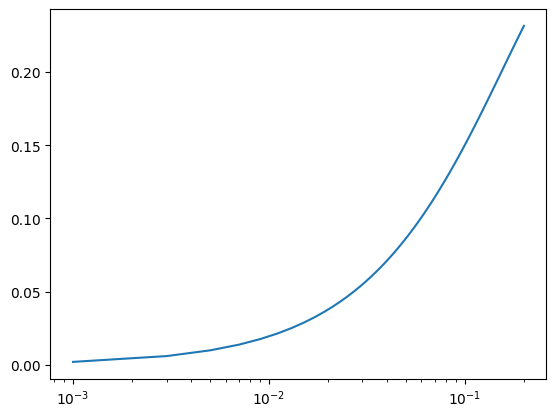

In [12]:
plt.plot(muv, Fid, label='Calculated')
plt.xscale('log')

This matches the results from Dhara et al. Let's look at the higher mean photon number

In [13]:
Fid = np.array([])
muv = np.linspace(10**(-3), 10, 100) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb = 0

spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 10**(-etdb/10) # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_fidelity()
    Fid = np.append(Fid, spdc_example.results["fidelity"])

100%|██████████| 100/100 [00:00<00:00, 136.00it/s]


In [14]:
Fid2 = np.array([])
muv = np.linspace(10**(-3), 10, 100) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb = 1

spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 10**(-etdb/10) # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_fidelity()
    Fid2 = np.append(Fid2, spdc_example.results["fidelity"])

100%|██████████| 100/100 [00:00<00:00, 107.52it/s]


In [15]:
Fid3 = np.array([])
muv = np.linspace(10**(-3), 10, 100) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb = 3

spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 10**(-etdb/10) # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_fidelity()
    Fid3 = np.append(Fid3, spdc_example.results["fidelity"])

100%|██████████| 100/100 [00:00<00:00, 106.03it/s]


Text(0, 0.5, 'Fidelity')

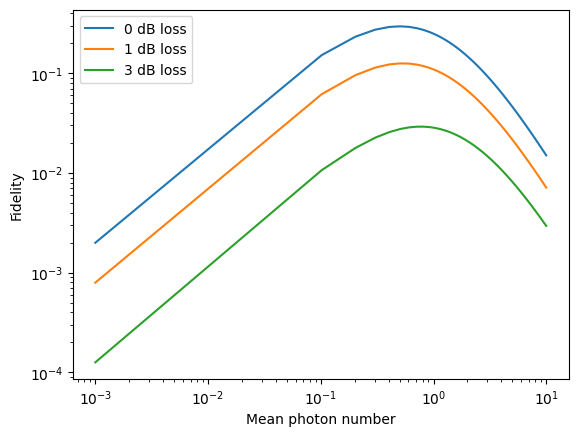

In [16]:
plt.plot(muv, Fid, label='0 dB loss')
plt.plot(muv, Fid2, label='1 dB loss')
plt.plot(muv, Fid3, label='3 dB loss')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Mean photon number')
plt.ylabel('Fidelity')

### Calculating the spin-spin density matrix

In [17]:
spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 1 # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

spdc_example.params["mean_photon"] = 10
spdc_example.run()
spdc_example.calculate_density_operator([0,1,0,1])
rho_un = spdc_example.results["output_state"]
rho_n = rho_un/np.trace(rho_un)

In [18]:
smp.Matrix(rho_un)

Matrix([
[  0.00187828700225394, -7.16827882635044e-21,  7.16827882635044e-21,  -0.00187828700225394],
[-3.58413941317522e-20,                     0,                     0,  3.58413941317522e-20],
[ 3.58413941317522e-20,                     0,                     0, -3.58413941317522e-20],
[ -0.00187828700225394,  7.16827882635044e-21, -7.16827882635044e-21,   0.00187828700225394]])

In [19]:
rho_n

array([[ 5.00000000e-01+0.j, -1.90819582e-18+0.j,  1.90819582e-18+0.j,
        -5.00000000e-01+0.j],
       [-9.54097912e-18+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         9.54097912e-18+0.j],
       [ 9.54097912e-18+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        -9.54097912e-18+0.j],
       [-5.00000000e-01+0.j,  1.90819582e-18+0.j, -1.90819582e-18+0.j,
         5.00000000e-01+0.j]])

In [20]:
(1/2)*(rho_un[0][0] - rho_un[0][3] - rho_un[3][0] + rho_un[3][3])/(rho_un[0][0] + rho_un[1][1] + rho_un[2][2] + rho_un[3][3])

np.complex128(1+0j)

### Calculating performance metrics

A key functionality of these tools is the ability to calculate performance metrics, such as fidelity, probability of success, and entanglement distribution rate. These performance metrics allow us to paint a picture about the source and how it operates in comparison to other sources, such as the cascaded source which we will consider later. 

In [21]:
Fidv = np.array([])
Psuc = np.array([])
muv = np.logspace(-4,1,20) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])
spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 1 # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_density_operator([0,1,0,1])
    rho_un = spdc_example.results["output_state"]
    Ps = np.trace(rho_un)
    Psuc = np.append(Psuc, Ps)
    Fidv = np.append(Fidv, (1/2)*(rho_un[0][0] - rho_un[0][3] - rho_un[3][0] + rho_un[3][3])/(Ps))

100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


In [22]:
Fidv2 = np.array([])
Psuc2 = np.array([])
spdc_example = SPDC()
spdc_example.params["outcoupling_efficiency"] = 10**(-3/10) # 1 dB of loss in the transmission
spdc_example.params["detection_efficiency"] = 10**(-3/10) # So that each mode has equal loss

for i in tqdm(muv):
    spdc_example.params["mean_photon"] = i
    spdc_example.run()
    spdc_example.calculate_density_operator([0,1,0,1])
    rho_un = spdc_example.results["output_state"]
    Psuc2 = np.append(Psuc2, np.trace(rho_un))
    Fidv2 = np.append(Fidv2, (1/2)*(rho_un[0][0] - rho_un[0][3] - rho_un[3][0] + rho_un[3][3])/(np.trace(rho_un)))

100%|██████████| 20/20 [00:07<00:00,  2.84it/s]


/Users/jgrrgb/Documents/GitHub/genqo/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jgrrgb/Documents/GitHub/genqo/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Fidelity')

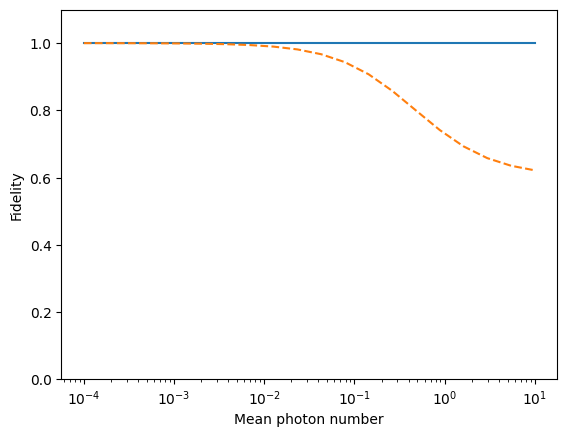

In [23]:
plt.plot(muv, Fidv, label='Calculated')
plt.plot(muv, Fidv2, label='Calculated, 3 dB loss, transmission and detection', linestyle='dashed')
plt.xscale('log')
plt.ylim(0,1.1)
plt.xlabel('Mean photon number')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Probability of success')

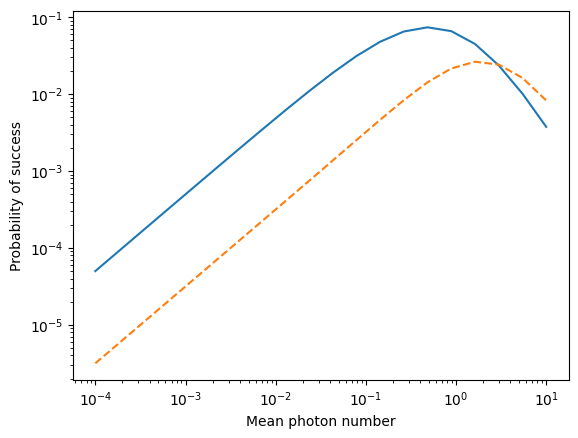

In [24]:
plt.plot(muv, Psuc, label='Calculated')
plt.plot(muv, Psuc2, label='Calculated, 3 dB loss, transmission and detection', linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean photon number')
plt.ylabel('Probability of success')

In [25]:
Psuc2

array([3.15490160e-06+0.j, 5.78304901e-06+0.j, 1.06008054e-05+0.j,
       1.94330434e-05+0.j, 3.56269920e-05+0.j, 6.53255987e-05+0.j,
       1.19813532e-04+0.j, 2.19855078e-04+0.j, 4.03757430e-04+0.j,
       7.42439784e-04+0.j, 1.36752880e-03+0.j, 2.52178528e-03+0.j,
       4.63539612e-03+0.j, 8.36728106e-03+0.j, 1.42962391e-02+0.j,
       2.16091001e-02+0.j, 2.64249341e-02+0.j, 2.42261088e-02+0.j,
       1.62602484e-02+0.j, 8.28593896e-03+0.j])

## Modeling a Cascaded source

A cascaded source is constructed in a manner similar to an SPDC such, but instead of it's constituent components being two TMSV states, it is two SPDC source states. What makes the cascade source unique is that a heralding bell state measurement occurs between the idler modes of each source, heralding the presence of bell state production deterministically in the presence of quantum memories at the receiver site. 

In this modeling process, we will sometimes refer to the Cascaded source as the ZALM source. Mathematically, the single-mode ZALM source is equivalent to the single-mode cascaded source. For higher mode, the ZALM source is the frequency multiplexed version of the source, whereas the cascaded source is the spatially multiplexed version of the source. Hence, for the single-mode analysis present in what follows, the terminology may be used interchangably. 

### Photon-photon state calculations

#### Calculating Probability of Generation of the photon-photon state

First, let's calculate the photon-photon probability of success for no loss

In [26]:
Pgenv = np.array([])
muv = np.linspace(10**(-4),20,200) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])
zalm_example = ZALM()
zalm_example.params["bsm_efficiency"] = 1 # 1 dB of loss in the BSM
zalm_example.params["outcoupling_efficiency"] = 1 # 1 dB of loss in the transmission
zalm_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    zalm_example.params["mean_photon"] = i
    zalm_example.run()
    zalm_example.calculate_probability_success()
    Pgenv = np.append(Pgenv, zalm_example.results["probability_success"])
    # Pgenv = np.append(Pgenv, (((1+i)**4))*zalm_example.results["probability_success"])

100%|██████████| 200/200 [00:01<00:00, 179.64it/s]


Next, for 3 dB of loss

In [27]:
Pgenv1 = np.array([])
# muv = np.linspace(10**(-4), 10, 20) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb1 = 3

zalm_example_loss_1 = ZALM()
# zalm_example_loss_1.params["bsm_efficiency"] = 10**(-etdb1/10) # 1 dB of loss in the BSM
# zalm_example_loss_1.params["outcoupling_efficiency"] = 10**(-etdb1/10) # 1 dB of loss in the transmission
# zalm_example_loss_1.params["detection_efficiency"] = 1 # So that each mode has equal loss


for i in tqdm(muv):
    zalm_example_loss_1.params["mean_photon"] = i
    zalm_example_loss_1.params["bsm_efficiency"] = 10**(-etdb1/10) # 1 dB of loss in the BSM
    zalm_example_loss_1.params["outcoupling_efficiency"] = 10**(-etdb1/10) # 1 dB of loss in the transmission
    zalm_example_loss_1.params["dark_counts"] = 0 # Introducing Dark Count probability
    zalm_example_loss_1.run()
    zalm_example_loss_1.calculate_probability_success()
    Pgenv1 = np.append(Pgenv1, zalm_example_loss_1.results["probability_success"])

100%|██████████| 200/200 [00:01<00:00, 167.51it/s]


For 5 dB loss

In [28]:
Pgenv2 = np.array([])
# muv = np.linspace(10**(-4), 10, 20) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb2 = 5

zalm_example_loss_2 = ZALM()
# zalm_example_loss_2.params["bsm_efficiency"] = 10**(-etdb2/10) # 1 dB of loss in the BSM
# zalm_example_loss_2.params["outcoupling_efficiency"] = 1 #10**(-etdb2/10) # 1 dB of loss in the transmission
# zalm_example_loss_2.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    zalm_example_loss_2.params["mean_photon"] = i
    zalm_example_loss_2.params["bsm_efficiency"] = 10**(-etdb2/10) # 1 dB of loss in the BSM
    zalm_example_loss_2.params["outcoupling_efficiency"] = 10**(-etdb2/10) # 1 dB of loss in the transmission
    zalm_example_loss_2.status = 0
    zalm_example_loss_2.run()
    zalm_example_loss_2.calculate_probability_success()
    Pgenv2 = np.append(Pgenv2, zalm_example_loss_2.results["probability_success"])
    # Pgenv2 = np.append(Pgenv2, (((1+i)**4))*zalm_example_loss_2.results["probability_success"])

100%|██████████| 200/200 [00:01<00:00, 177.28it/s]


Now, let's define the analytical expressions, derived in the original cascaded source papers

In [29]:
def PgenP(mu):
    num = mu**2
    den = (1 + mu)**6
    return num/den

Now let's compare in a plot

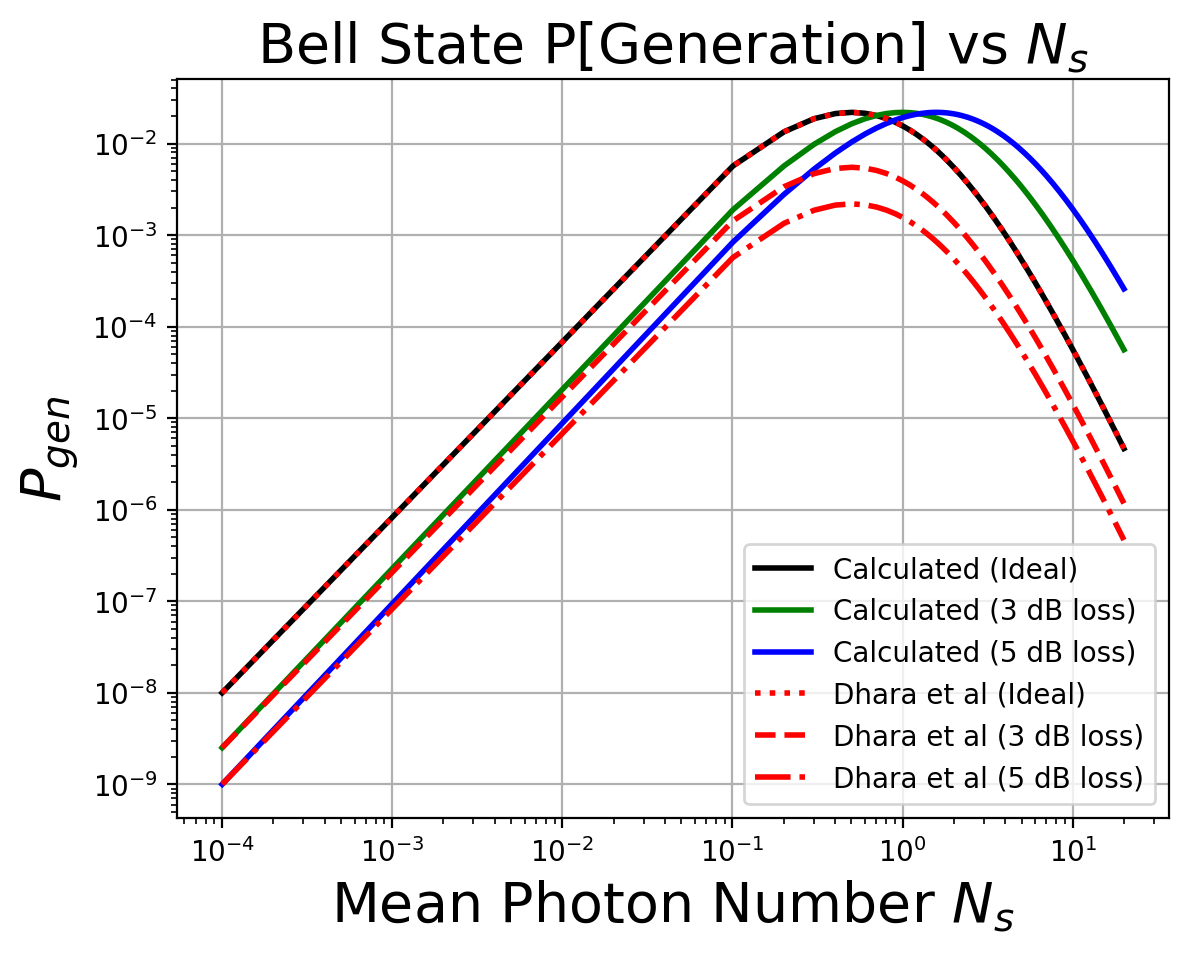

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.figure(dpi = 200)
plt.plot(muv, Pgenv, label='Calculated (Ideal)', color='black', linestyle='-', linewidth=2) 
plt.plot(muv, Pgenv1, label='Calculated (3 dB loss)', color='green', linestyle='-', linewidth=2) 
plt.plot(muv, Pgenv2, label='Calculated (5 dB loss)', color='blue', linestyle='-', linewidth=2) 

plt.plot(muv, PgenP(muv), label='Dhara et al (Ideal)', color='red', linestyle=':', linewidth=2)
plt.plot(muv, ((10**(-etdb1/10))**2)*PgenP(muv), label='Dhara et al (3 dB loss)', color='red', linestyle='--', linewidth=2)
plt.plot(muv, ((10**(-etdb2/10))**2)*PgenP(muv), label='Dhara et al (5 dB loss)', color='red', linestyle='dashdot', linewidth=2)

plt.xlabel(r'Mean Photon Number $N_s$', fontsize = 20)
plt.ylabel(r'$P_{gen}$', fontsize = 20)
plt.title(r'Bell State P[Generation] vs $N_s$', fontsize = 20)


plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.grid(True)
# plt.savefig('Pgen_vs_Ns_gauss.png')


We can observe that in the low mean photon number regime, the hybrid modeling approach matches the results of the paper, but in the high mean photon number regime they do not. This showcases the power of the hybrid modeling approach as mean photon number approximations are not needed. In particular, we see a discrepancy in the effect of loss. With the approximate approach, we see that we would expect a single optimized value for the mean photon number to maximize the probability of success. In reality, for high loss the peak probability of success shifts towards higher mean photon number values. 

Now, let's include dark clicks

In [31]:
def P_dark_vec(etad_db, Pd, muv):
    Pdv1 = np.array([])
    for i in tqdm(muv):
        Pdv1 = np.append(Pdv1, ZALM.psucc_value(1, 1, 10**(-etad_db/10), i, Pd))
    return Pdv1

100%|██████████| 20/20 [00:00<00:00, 253.59it/s]


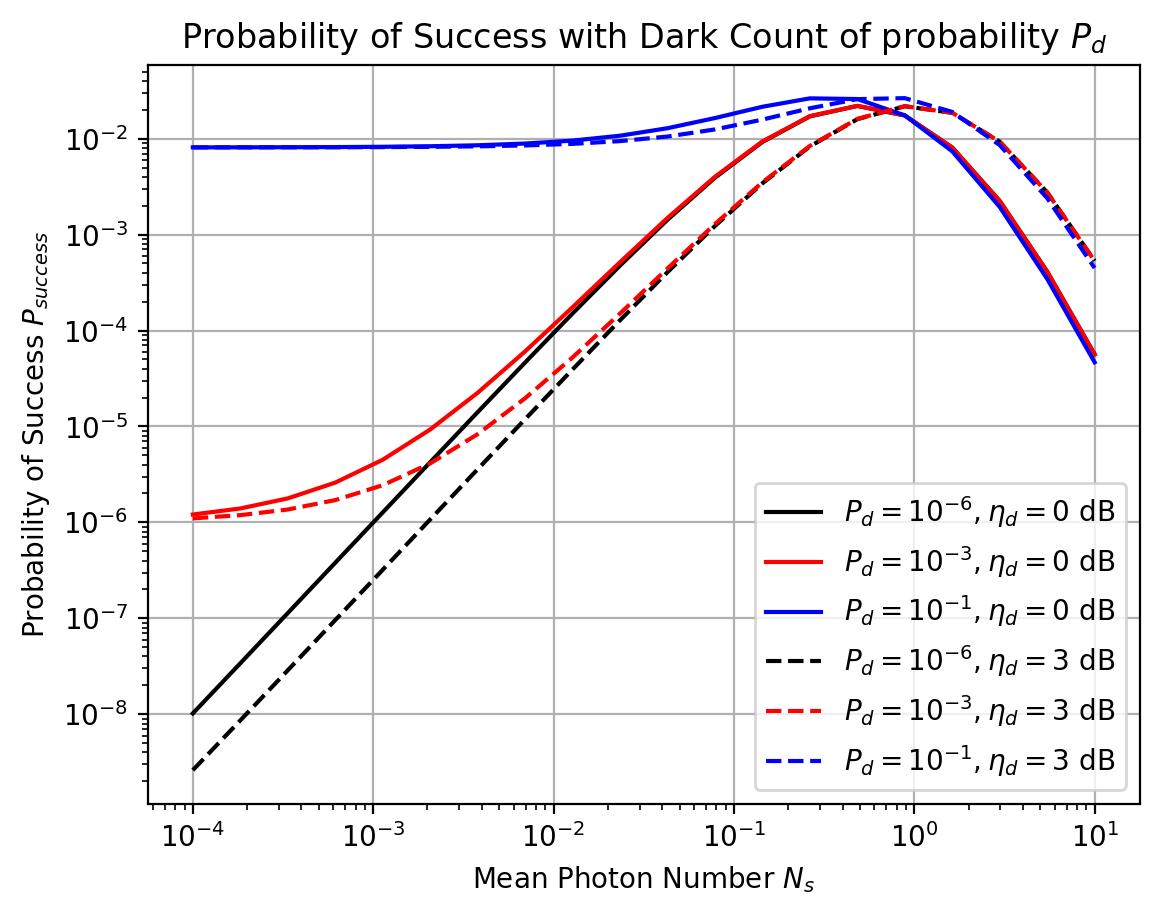

In [32]:
muv = np.logspace(-4, 1, 20)
edb1 = 0
edb2 = 3

plt.figure(dpi = 200)
plt.plot(muv, P_dark_vec(edb1, 10**(-6), muv), label=r'$P_d = 10^{-6}, \eta_d = 0$ dB', color='black', linestyle='-')
plt.plot(muv, P_dark_vec(edb1, 10**(-3), muv), label=r'$P_d = 10^{-3}, \eta_d = 0$ dB', color='red', linestyle='-')
plt.plot(muv, P_dark_vec(edb1, 10**(-1), muv), label=r'$P_d = 10^{-1}, \eta_d = 0$ dB', color='blue', linestyle='-')

plt.plot(muv, P_dark_vec(edb2, 10**(-6), muv), label=r'$P_d = 10^{-6}, \eta_d = 3$ dB', color='black', linestyle='--')
plt.plot(muv, P_dark_vec(edb2, 10**(-3), muv), label=r'$P_d = 10^{-3}, \eta_d = 3$ dB', color='red', linestyle='--')
plt.plot(muv, P_dark_vec(edb2, 10**(-1), muv), label=r'$P_d = 10^{-1}, \eta_d = 3$ dB', color='blue', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.title(rf'Probability of Success with Dark Count of probability $P_d$')
plt.xlabel(r'Mean Photon Number $N_s$')
plt.ylabel(r'Probability of Success $P_{success}$')
plt.legend()
plt.grid(True)
#plt.savefig('Psucc_vs_Ns_varyPd.png')

#### Calculating the fidelity of the photon-photon state 

In [33]:
Fidl4 = np.array([])
muv = np.linspace(10**(-4), 0.1, 2) #np.array([10**(-4), 0.001, 0.01, 0.05, 0.1, 0.2])

etdb4 = 1

zalm_fid_loss_4 = ZALM()
zalm_fid_loss_4.params["bsm_efficiency"] = 10**(-etdb4/10) # 1 dB of loss in the BSM
zalm_fid_loss_4.params["outcoupling_efficiency"] = 1 #10**(-etdb4/10) # 1 dB of loss in the transmission
zalm_fid_loss_4.params["detection_efficiency"] = 1 # So that each mode has equal loss

for i in tqdm(muv):
    zalm_fid_loss_4.params["mean_photon"] = i
    zalm_fid_loss_4.run()
    zalm_fid_loss_4.calculate_fidelity()
    Fidl4 = np.append(Fidl4, zalm_fid_loss_4.results["fidelity"])

100%|██████████| 2/2 [00:19<00:00,  9.78s/it]


In [34]:
Fidl4

array([0.499938307836587, 0.446465200122824], dtype=object)

These numbers are consistent with the results from the cascaded source paper (see figure 9)

#### Calculating the photon-photon density matrix

One of the principle advantages of the hybrid approach is the flexibility in what can be calculated. We have complete access to any density matrix element, and as such can choose desired approximations such as photon number cut off. This tunability in approximations is what will likely make this approach widely usable for other applications beyond those considered here. In the hybrid_model_functions.py file we have functions for calculating the photon-photon density matrix up to a 4 photon cut off. 

### Spin-spin state

Calculating the spin-spin state is the most complicated calculation thus far as it requires calculating sums of higher order moments. The higher the order of the moment, the more computaitonally intense the calculation. Therefore, in this section we provide the scafolding for hold to calculate the spin-spin state, but the results show come from trials that were previously calculated. 

In [35]:
## For example, with no loss or dark clicks
# mem_example = ZALM()
# mem_example.params["bsm_efficiency"] = 1 # 0 dB of loss in the BSM
# mem_example.params["outcoupling_efficiency"] = 1 # 0 dB of loss in the transmission
# mem_example.params["detection_efficiency"] = 1 # So that each mode has equal loss

# mem_example.params["mean_photon"] = 10**(-3)
# mem_example.run()
# rhoi = mem_example.calculate_density_operator(np.array([1,0,1,1,0,0,1,0]))

First, let's load in the data of previously calculated trails of spin-spin density matrices

In [40]:
saved_data_ideal = hkl.load("ideal_states.hkl")

In [41]:
saved_data_ideal

{'mu = 1e-4': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37905,), dtype=uint8),
 'mu = 1e-3': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37913,), dtype=uint8),
 'mu = 1e-2': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37906,), dtype=uint8),
 'mu = 1e-1': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37906,), dtype=uint8),
 'mu = 1': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37826,), dtype=uint8),
 'mu = 1e1': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37905,), dtype=uint8),
 'mu = 20': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37906,), dtype=uint8),
 'mu = 1e2': RecoveredDataset([128,   4, 149, ..., 117,  98,  46],
                  shape=(37826,), dtype=uint8),
 'description': 'Calculated ideal spin-spin density matrices'}

Next, let's calculate the probability of success for these trials

In [42]:
muv = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 20, 1e2]
ps = []
psc = []
ks = ["mu = 1e-4", "mu = 1e-3", "mu = 1e-2", "mu = 1e-1", "mu = 1", "mu = 1e1", "mu = 20", "mu = 1e2"]
for i in ks:
    ps.append(np.trace(saved_data_ideal[i].results["output_state"]))
    saved_data_ideal[i].calculate_probability_success()
    psc.append(saved_data_ideal[i].results["probability_success"])

AttributeError: 'RecoveredDataset' object has no attribute 'results'

Next, let's calculate the probability of success for the photon-photon case

In [7]:
def compute_pgen(muval, etaval):
        dmat_calc_1 = ZALM()

        dmat_calc_1.params["bsm_efficiency"] = etaval 
        # dmat_calc_1.params["outcoupling_efficiency"] = etaval 
        dmat_calc_1.params["mean_photon"] = muval
        dmat_calc_1.run()
        dmat_calc_1.calculate_probability_success()
        dmtest = dmat_calc_1.results["probability_success"]
        return dmtest

muv_ext = np.logspace(-4, 2, 100)
pp_pgen = []
for i in muv_ext:
    pp_pgen.append(compute_pgen(i, 1))

Finally, let's plot them to compare

In [22]:
def PgenJ(mu, eta):
    num = 4*(eta*mu)**2
    den = (1 + (eta*mu))**6
    return num/den

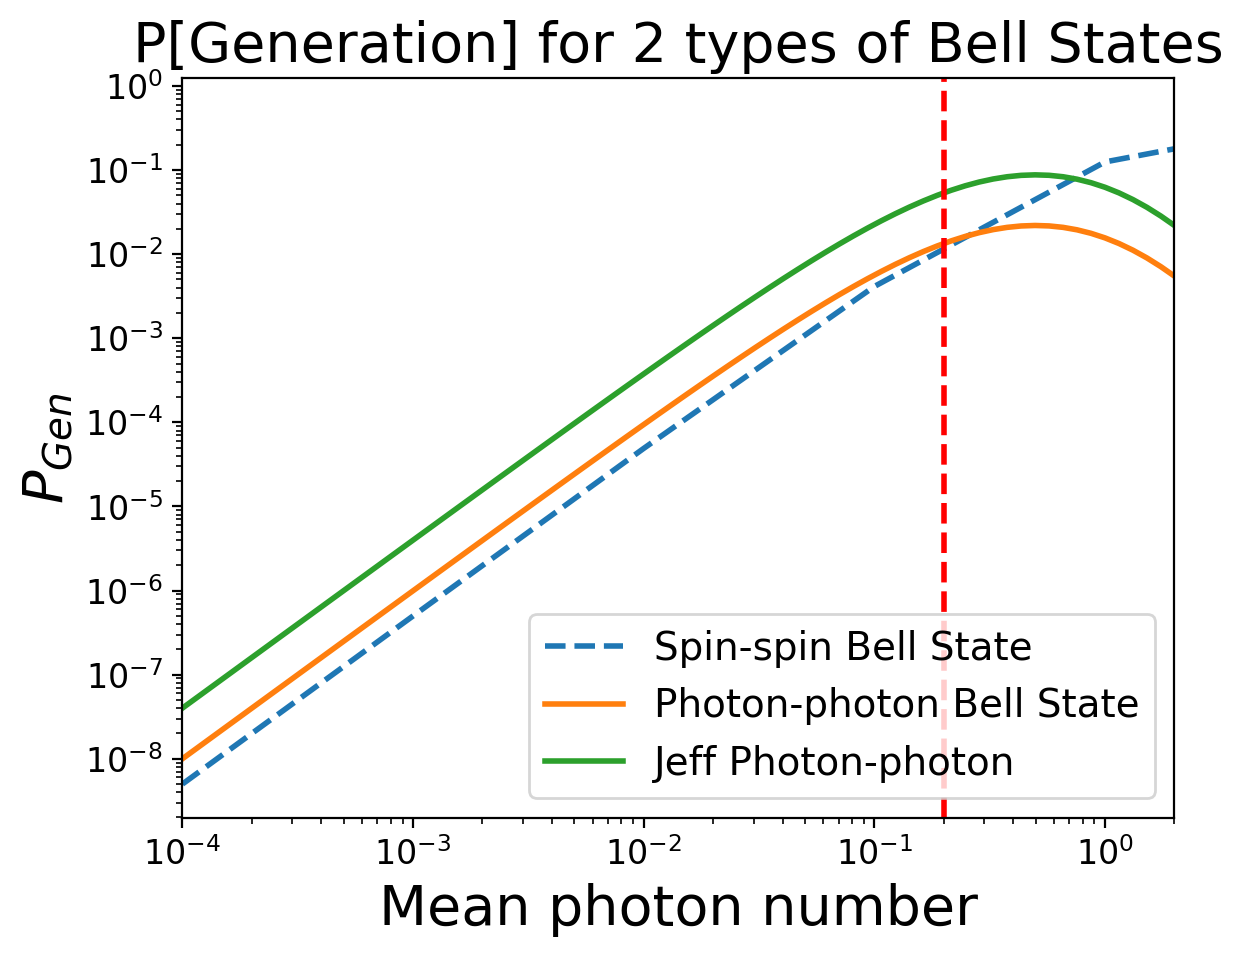

In [26]:
import matplotlib.pyplot as plt
plt.figure(dpi = 200)
# plt.plot(muv, 1-(1-4*np.array(ps))**(100), label="Spin-spin Bell State", linestyle="--", linewidth=2)
# # plt.plot(muv, np.array(psc), label="Photon-photon Bell State", linewidth=2)
# plt.plot(muv_ext, (1-(1-4*np.array(pp_pgen))**100)/2, label="Photon-photon Bell State", linewidth=2)
# plt.plot(muv_ext, (1-(1-PgenJ(muv_ext, 1))**100)/2, label="Jeff Photon-photon", linewidth=2)

plt.plot(muv, np.array(ps), label="Spin-spin Bell State", linestyle="--", linewidth=2)
# plt.plot(muv, np.array(psc), label="Photon-photon Bell State", linewidth=2)
plt.plot(muv_ext, np.array(pp_pgen), label="Photon-photon Bell State", linewidth=2)
plt.plot(muv_ext, PgenJ(muv_ext, 1), label="Jeff Photon-photon", linewidth=2)


# Add a vertical line at x = 5
plt.axvline(x=0.2, color='red', linestyle='--', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.xlim(10**(-4), 2)
plt.xlabel("Mean photon number", fontsize=20)
plt.ylabel(r"$P_{Gen}$", fontsize=20)
plt.title("P[Generation] for 2 types of Bell States", fontsize=20)
plt.yscale("log")
plt.xscale("log")

plt.show()

In [24]:
1-(1-4*np.array(ps))**(100)

array([1.99959808e-06+0.00000000e+00j, 1.99580879e-04+0.00000000e+00j,
       1.94168597e-02+0.00000000e+00j, 8.11131684e-01+0.00000000e+00j,
       1.00000000e+00+0.00000000e+00j, 1.00000000e+00-5.98961748e-34j,
       9.99999999e-01-2.28461436e-24j, 9.82056754e-01-3.52474741e-17j])

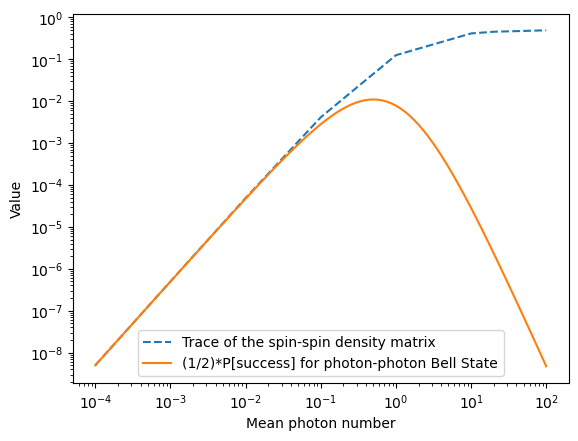

In [92]:
import matplotlib.pyplot as plt
plt.plot(muv, ps, label="Trace of the spin-spin density matrix", linestyle="--")
plt.plot(muv_ext, (1/2)*np.array(pp_pgen), label="(1/2)*P[success] for photon-photon Bell State", linestyle="-")
plt.legend()
plt.xlabel("Mean photon number")
plt.ylabel("Value")
plt.yscale("log")
plt.xscale("log")

We see that in the low mean photon number regime, the probability of success for the spin-spin state matches the probability of success of the photon-photon state by a factor of 1/2, as expected. But, as the mean photon number increases, the spin-spin state probability of success increases to a plateu while the photon-photon one drops. This is a characteristic of the spin-spin system still using those lower order terms for loading even when the probability of the higher order terms increases. 